# Optical RL-Gym

## Training the Stable Baselines agents using the DeepRMSA environment

This file contains examples of how to train agents for the DeepRMSA environment.

The agents used in this file come from the [Stable-baselines3](https://github.com/DLR-RM/stable-baselines3) framework.

Before running this notebook, make sure to install Stable-Baselines3 and the Optical RL-Gym in your Python environment (see the requirements.txt file in this folder).

### General imports

In [1]:
import os
import gym
import pickle
import numpy as np

from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Stable Baselines imports

In [2]:
import stable_baselines3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common import results_plotter
stable_baselines3.__version__

'1.6.0'

### Environment imports

In [3]:
import gym
from optical_rl_gym.envs.qos_constrained_ra import MatrixObservationWithPaths

### Define a callback function

In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                 # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("Num timesteps: {} - ".format(self.num_timesteps), end="")
                    print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))
                  # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print("Saving new best model to {}".format(self.save_path))
                        self.model.save(self.save_path)
                if self.verbose > 0:
                    clear_output(wait=True)

        return True

### Setting up the environment

The parameters are set as in the [this work](https://doi.org/10.1364/NETWORKS.2018.NeW3F.5).

In [5]:
env_args = dict(seed=10, allow_rejection=True,
                load=50, episode_length=100, num_spectrum_resources=16, k_paths=3,
                num_service_classes=2,
                classes_arrival_probabilities=[0.5, 0.5],
                classes_reward=[10., 1.])

### Creating the monitors and agent

In [6]:
# Create log dir
log_dir = "./tmp/qosconstrainedra-ppo/"
os.makedirs(log_dir, exist_ok=True)
callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)

env = gym.make('QoSConstrainedRA-v0', **env_args)

# uses a matrix observation with paths
env = MatrixObservationWithPaths(env)

# logs will be saved in log_dir/monitor.csv
# in our case, on top of the usual monitored metrics, we also monitor service blocking rate
env = Monitor(env, log_dir + 'training', info_keywords=('episode_service_blocking_rate',))

policy_args = dict(net_arch=5*[128]) # the neural network has four layers with 150 neurons each

agent = PPO(MlpPolicy, env, verbose=0, tensorboard_log="./tb/PPO-QoSConstrainedRA-v0/", policy_kwargs=policy_args, gamma=.95, learning_rate=10e-5)

TypeError: OpticalNetworkEnv.__init__() got an unexpected keyword argument 'k_paths'

### Training the agent

In [ ]:
agent.learn(total_timesteps=100000, callback=callback)

### Plotting the training progress

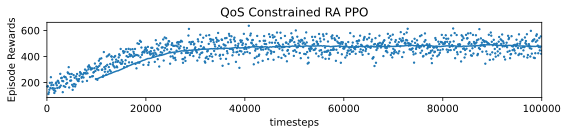

In [ ]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "QoS Constrained RA PPO")